# **Code Implementation**

This code implements PPO algorithm to finetune trained DDPM. <br>
Refer to:<br>


*   Paper1 : Proximal policy optimization algorithm (2017)
*   Paper2 : 3D-HLDM: ... (2024)

We have a DDPM model trained with CelebA dataset. Reward model is trained with real dataset of CelebA and fake dataset of synthetic image generated by DDIM. Using this model, we aim to finetune trained DDPM to attain higher reward model score while generating realistic image by sampling process.


Below is the formula of L_CLIP used in PPO algorithm.

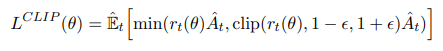

We regard the entire reverse process as a single epsiode with a single timestep. $\hat{A}_t$ in the formula is caculated by the trained reward model and its paramters are fixed during the train. $r_t(\theta)=\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ can be caculated ananlytically using the knowledge of DDPM as in the below.

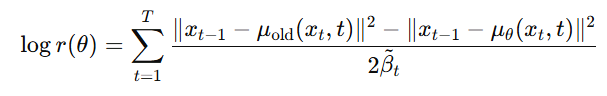

So we can compute the value of L_CLIP in each episodes. In each episodes, we iter the entire DDIM reverse process to obtain $r(\theta)$ and $\hat{A}$ and backpropagate it. But this method requires too large GPU memory since it preserves all the gradient graph of the whole timestep of the reverse process.

To avoid GPU memory issue, we divide the backpropagation of a single episode into two steps. In the first step, we run the reverse process without gradient calculating, and only saves $x_t$, $\epsilon_t$ in all timesteps and calculate $\hat{A}$ with the resulting $x_0$. In the second step, we compute the gradient of $\log r_t(\theta)$ and compute the gradient of each timestep. Note that we compute the gradient step by step so that we do not have to save the whole computation graph. This method let us save the GPU memory. Then we can compute the gradient of L_CLIP by the below formula using the gradient of $\log r_t(\theta)$. The algorithm is implemented in the function L_CLIP_two_pass.

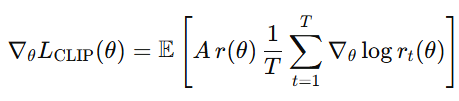

# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, copy, math, time, random
import torch
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import torch
import random
from torchvision import transforms
import glob
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

# DDPM Setup

In [3]:
# Model
def swish(x):
    return x * torch.sigmoid(x)

def get_timestep_embedding(t, channel):
    half = channel // 2
    device = t.device
    inv_freq = torch.exp(-math.log(10000) * torch.arange(half) / half).to(device)
    args = t.float().unsqueeze(1) * inv_freq.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    return emb

class GroupNorm(nn.GroupNorm):
    def __init__(self, num_channels, num_groups=8, eps=1e-6):
        super().__init__(num_groups, num_channels, eps=eps)

def conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True, init_scale=1.0):
    conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=bias)
    with torch.no_grad():
        conv.weight.data *= init_scale
    return conv

def nin(in_ch, out_ch, init_scale=1.0):
    layer = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)
    with torch.no_grad():
        layer.weight.data *= init_scale
    return layer

def linear(in_features, out_features, init_scale=1.0):
    fc = nn.Linear(in_features, out_features)
    with torch.no_grad():
        fc.weight.data *= init_scale
    return fc

class DownsampleBlock(nn.Module):
    def __init__(self, channels, with_conv=True):
        super().__init__()
        if with_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        return self.op(x)

class UpsampleBlock(nn.Module):
    def __init__(self, channels, with_conv=True):
        super().__init__()
        self.with_conv = with_conv
        if with_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0, mode='nearest')
        if self.with_conv:
            x = self.conv(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels=256, dropout=0.0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.temb_channels = temb_channels
        self.dropout = dropout
        self.norm1 = GroupNorm(self.in_channels)
        self.conv1 = conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=1, init_scale=1.0)
        self.temb_proj = linear(self.temb_channels, self.out_channels, init_scale=1.0)
        self.norm2 = GroupNorm(self.out_channels)
        self.conv2 = conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, init_scale=1.0)
        self.conv_shortcut = nin(self.in_channels, self.out_channels)

    def forward(self, x, temb):
        h = self.norm1(x)
        h = swish(h)
        h = self.conv1(h)
        h_temb = swish(temb)
        h_temb = self.temb_proj(h_temb)
        h_temb = h_temb[:, :, None, None]
        h = h + h_temb
        h = self.norm2(h)
        h = swish(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.conv2(h)
        x = self.conv_shortcut(x)
        return x + h

class AttnBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = GroupNorm(channels)
        self.q = nin(channels, channels)
        self.k = nin(channels, channels)
        self.v = nin(channels, channels)
        self.proj_out = nin(channels, channels, init_scale=0.0)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h)
        k = self.k(h)
        v = self.v(h)
        q = q.view(B, C, H * W).permute(0, 2, 1)
        k = k.view(B, C, H * W).permute(0, 2, 1)
        v = v.view(B, C, H * W).permute(0, 2, 1)
        scale = q.shape[-1] ** -0.5
        attn = torch.softmax(torch.bmm(q, k.transpose(1, 2)) * scale, dim=-1)
        h_ = torch.bmm(attn, v)
        h_ = h_.permute(0, 2, 1).reshape(B, C, H, W)
        h_ = self.proj_out(h_)
        return x + h_

class DDPMModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        ch=64,
        ch_mult=(1, 2, 4),
        num_res_blocks=2,
        attn_resolutions={32},
        dropout=0.0,
        resamp_with_conv=False,
        init_resolution=64
    ):
        super().__init__()
        self.ch = ch
        self.ch_mult = ch_mult
        self.num_res_blocks = num_res_blocks
        self.attn_resolutions = attn_resolutions
        self.dropout = dropout
        self.num_levels = len(ch_mult)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.resamp_with_conv = resamp_with_conv
        self.init_resolution = init_resolution
        self.temb_ch = ch * 4
        self.temb_dense0 = linear(self.ch, self.temb_ch)
        self.temb_dense1 = linear(self.temb_ch, self.temb_ch)
        self.conv_in = conv2d(in_channels, ch, kernel_size=3, stride=1, padding=1)
        self.down_blocks = nn.ModuleList()
        curr_ch = ch
        curr_res = init_resolution
        for level in range(self.num_levels):
            level_blocks = nn.ModuleList()
            out_ch = ch * ch_mult[level]
            for i in range(num_res_blocks):
                level_blocks.append(ResnetBlock(curr_ch, out_ch, temb_channels=self.temb_ch, dropout=dropout))
                if curr_res in attn_resolutions:
                    level_blocks.append(AttnBlock(out_ch))
                curr_ch = out_ch
            self.down_blocks.append(level_blocks)
            if level != self.num_levels - 1:
                self.down_blocks.append(DownsampleBlock(curr_ch, with_conv=resamp_with_conv))
                curr_res //= 2
        self.mid_block = nn.ModuleList([
            ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout),
            AttnBlock(curr_ch),
            ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout)
        ])
        self.up_blocks = nn.ModuleList()
        for level in reversed(range(self.num_levels)):
            level_blocks = nn.ModuleList()
            out_ch = ch * ch_mult[level]
            level_blocks.append(ResnetBlock(curr_ch + out_ch, out_ch, temb_channels=self.temb_ch, dropout=dropout))
            if (init_resolution // (2 ** level)) in attn_resolutions:
                level_blocks.append(AttnBlock(out_ch))
            curr_ch = out_ch
            for i in range(num_res_blocks):
                level_blocks.append(ResnetBlock(curr_ch, curr_ch, temb_channels=self.temb_ch, dropout=dropout))
                if (init_resolution // (2 ** level)) in attn_resolutions:
                    level_blocks.append(AttnBlock(curr_ch))
            if level != 0:
                level_blocks.append(UpsampleBlock(curr_ch, with_conv=resamp_with_conv))
            self.up_blocks.append(level_blocks)
        self.norm_out = GroupNorm(curr_ch)
        self.conv_out = conv2d(curr_ch, out_channels, kernel_size=3, stride=1, padding=1, init_scale=0.0)

    def forward(self, x, t):
        temb = get_timestep_embedding(t, self.ch)
        temb = self.temb_dense0(temb)
        temb = swish(temb)
        temb = self.temb_dense1(temb)
        skips = []
        h = self.conv_in(x)
        down_iter = iter(self.down_blocks)
        for level in range(self.num_levels):
            blocks = next(down_iter)
            for layer in blocks:
                h = layer(h, temb) if isinstance(layer, ResnetBlock) else layer(h)
            skips.append(h)
            if level != self.num_levels - 1:
                downsample = next(down_iter)
                h = downsample(h)
        for layer in self.mid_block:
            h = layer(h, temb) if isinstance(layer, ResnetBlock) else layer(h)
        for level in range(self.num_levels):
            blocks = self.up_blocks[level]
            skip = skips.pop()
            h = torch.cat([h, skip], dim=1)
            h = blocks[0](h, temb)
            for layer in blocks[1:]:
                if isinstance(layer, ResnetBlock):
                    h = layer(h, temb)
                else:
                    h = layer(h)
        h = self.norm_out(h)
        h = swish(h)
        h = self.conv_out(h)
        return h

# Sampling
def p_sample_ddim(model, x_t, t_cur, t_prev, alphas_cumprod, eta=0.0):
    alpha_bar_t = alphas_cumprod[t_cur - 1]
    if t_prev > 0:
        alpha_bar_prev = alphas_cumprod[t_prev - 1]
    else:
        alpha_bar_prev = torch.tensor(1.0, device=x_t.device)
    sigma_t = eta * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar_t)) * torch.sqrt(1 - alpha_bar_t / alpha_bar_prev)
    B = x_t.size(0)
    t_tensor = torch.full((B,), t_cur, device=x_t.device, dtype=torch.long)
    eps_theta = model(x_t, t_tensor)
    sqrt_ab_t = torch.sqrt(alpha_bar_t)
    sqrt_ab_prev = torch.sqrt(alpha_bar_prev)
    x0_pred = (x_t - torch.sqrt(1 - alpha_bar_t).view(-1, 1, 1, 1) * eps_theta) / sqrt_ab_t.view(-1, 1, 1, 1)
    dir_xt = torch.sqrt(torch.clamp(1 - alpha_bar_prev - sigma_t**2, min=0.0)).view(-1, 1, 1, 1) * eps_theta
    noise = torch.randn_like(x_t) if t_prev > 0 else torch.zeros_like(x_t)
    x_prev = sqrt_ab_prev.view(-1, 1, 1, 1) * x0_pred + dir_xt + sigma_t.view(-1, 1, 1, 1) * noise
    return x_prev, eps_theta.detach().cpu(), x_t.detach().cpu()

def sample_ddim(model, shape, alphas_cumprod, device, ddim_steps, eta=0.0):
    steps_log = {"t": [], "eps_t": [], "x_t": []}
    num_timesteps = alphas_cumprod.shape[0]
    x = torch.randn(shape, device=device)
    idx_lin = torch.linspace(0, num_timesteps - 1, steps=ddim_steps + 1, device=device)
    idx0 = idx_lin.round().long()
    idx0 = torch.cat([torch.tensor([0, num_timesteps - 1], device=device, dtype=torch.long), idx0]).unique(sorted=True)
    seq_asc = idx0 + 1
    seq_rev = torch.flip(seq_asc, dims=[0])
    seq = torch.cat([seq_rev, torch.tensor([0], device=device, dtype=torch.long)])
    prev_t = seq[0].item()
    for next_t in seq[1:]:
        t_cur = prev_t
        t_prev = next_t.item()
        x, eps_t, x_t_snap = p_sample_ddim(
            model,
            x,
            t_cur,
            t_prev,
            alphas_cumprod,
            eta
        )
        steps_log["t"].append(t_cur)
        steps_log["eps_t"].append(eps_t)
        steps_log["x_t"].append(x_t_snap)
        prev_t = t_prev
    return x, steps_log

# Get alpha_bar
def get_beta_alpha_linear(beta_start=0.0001, beta_end=0.02, num_timesteps=1000):
    betas = np.linspace(beta_start, beta_end, num_timesteps, dtype=np.float32)
    betas = torch.tensor(betas)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    return betas, alphas, alphas_cumprod

# Reward Model

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, kernel=3, stride=1, padding=1, pool=True):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.GELU()
        self.pool = nn.AvgPool2d(2) if pool else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.pool(x)
        return x

class RewardModel(nn.Module):
    def __init__(self, in_channels=3, base_channels=32, dropout=0.2):
        super().__init__()
        b = base_channels
        self.blocks = nn.Sequential(
            ConvBlock(in_channels, b, pool=True),
            ConvBlock(b, b*2, pool=True),
            ConvBlock(b*2, b*4, pool=True),
            ConvBlock(b*4, b*8, pool=True),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(b*8, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.blocks(x)
        x = self.head(x)
        return x.view(-1)

# PPO Algorithm

In [5]:
def compute_mu_from_eps(x_t, t_idx, eps_pred, alphas, alpha_bars):
    """
    Compute mu(mean) from epsilon which is predicted by model.
    The value of mu is used to compute the ratio of the value of policy

    Parameters:
        x_t (torch.Tensor) : Predicted image tensor at timestep t during the sampling process.
        t_idx (int) : Number of the timestep.
        eps_pred (torch.Tensor) : The value of epsilon predicted by model.
        alphas (torch.Tensor) : Tensor of alphas.
        alpha_bars (torch.Tensor) : Tensor of alpha_bars.

    Returns:
        torch.Tensor : mu(mean)
    """
    T = alphas.shape[0]
    if t_idx < 0:
        t_idx = 0
    if t_idx > T - 1:
        t_idx = T - 1

    alpha_t = alphas[t_idx].to(x_t.device, dtype=torch.float32).view(-1, 1, 1, 1)
    beta_t  = (1.0 - alphas[t_idx].to(x_t.device, dtype=torch.float32)).view(-1, 1, 1, 1)
    abar_t  = alpha_bars[t_idx].to(x_t.device, dtype=torch.float32).view(-1, 1, 1, 1)
    denom = torch.sqrt(torch.clamp(1.0 - abar_t, min=1e-12))
    num   = beta_t * eps_pred.to(torch.float32)

    mu = (x_t.to(torch.float32) - (num / denom)) / torch.sqrt(torch.clamp(alpha_t, min=1e-12))

    return mu.to(x_t.dtype)

def compute_log_r_sum(cur_model, steps_log, x0_cpu,
                      alphas_cumprod, device, eta, eps_to_mu_fn,
                      per_step_clip=5.0, global_clip=10.0, sigma_floor=1e-3):
    """
    Compute the log of the sum of the r.
    r is the value of the ratio of the policy probability function, as in the PPO algorithm.
    This function not only computes log_r_sum, but also the gradients of each parameters.

    Parameters:
        cur_model (torch.nn.Module) : The model updated most recently.
        steps_log (dictionary) : Dictionary of t, x_t, epsilon of each timestep while sampling.
        x0_cpu (torch.Tensor) : Image tensor computed by reverse(sampling) process.
        alphas_cumprod (torch.Tensor) : Tensor of alpha_bars.
        device (torch.device) : Device.
        eta (float) : The ratio of probabilistic process in the DDPM(DDIM) reverse process.
        eps_to_mu_fn (function) : Function to compute mu(mean) from epsilon.
        per_step_clip (float) : Clipping value of log r_t in each timestep.
        global_clip (float) : Clipping value of log_r_sum.
        simga_floor (float) : Minimum clipping value of sigma to avoid sigma to be too small.

    Returns:
        float : log_r_sum. Summation is done in each timestep.
        list of tensors : sum_grads. List of gradients of each parameters. Summation is done in each timestep.
    """
    params = [p for p in cur_model.parameters() if p.requires_grad]
    sum_grads = [torch.zeros_like(p) for p in params]
    log_r_sum = 0.0

    Tlist = steps_log["t"]
    Xlist = steps_log["x_t"]
    Elist = steps_log["eps_t"]

    total_steps = len(Tlist)

    # Iter each step and compute r in each step.
    for k in range(total_steps):
        t_cur  = int(Tlist[k])
        t_prev = int(Tlist[k+1]) if (k+1) < total_steps else 0

        # Skip deterministic last-step
        if t_prev == 0:
            continue

        # Load data on GPU
        x_t = Xlist[k].to(device).detach()
        x_tprev = Xlist[k+1].to(device).detach() if (k+1)<len(Xlist) else x0_cpu.to(device).detach()
        eps_old = Elist[k].to(device).detach()

        # Compute mu_old. mu_old is computed by eps_old which is computed by old_model.
        mu_old = eps_to_mu_fn(x_t, t_cur-1, eps_old).detach()

        # Compute mu_cur. mu_cur is computed by eps_cur which is computed by cur_model.
        t_tensor = torch.full((x_t.size(0),), t_cur, device=device, dtype=torch.long)
        eps_cur  = cur_model(x_t, t_tensor)  # requires_grad=True
        mu_cur = eps_to_mu_fn(x_t, t_cur-1, eps_cur)

        # Compute sigma_t to use in DDIM sampling steps.
        a_t = alphas_cumprod[t_cur-1].to(device).float()
        if t_prev > 0:
            a_prev = alphas_cumprod[t_prev-1].to(device).float()
            num = torch.clamp(1.0-a_prev, min=0.0)
            denom = torch.clamp(1.0-a_t, min=1e-12)
            frac = torch.clamp(num/denom,  min=0.0, max=1.0)
            term = torch.clamp(1.0 - (a_t/a_prev), min=0.0)
            c1 = torch.sqrt(frac)
            c2 = torch.sqrt(term)
        else:
            c1 = torch.tensor(1.0, device=device, dtype=torch.float32)
            c2 = torch.tensor(0.0, device=device, dtype=torch.float32)
        sigma_t = (eta * c1 * c2).to(x_t.dtype)
        sigma_t = torch.clamp(sigma_t, min=float(sigma_floor))

        # Compute log r_t.
        diff_cur = (x_tprev - mu_cur).pow(2).mean() # Use mean so that the scale of the value is preserved.
        diff_old = (x_tprev - mu_old).pow(2).mean()
        denom = 2.0 * (sigma_t**2) + 1e-12
        log_r_t  = - (diff_cur-diff_old) / denom

        # Clamp before autodiff to avoid exploding grads.
        log_r_t_clamped = torch.clamp(log_r_t, -per_step_clip, per_step_clip)

        # Compute grads on clamped log value.
        grads_t = torch.autograd.grad(log_r_t_clamped, params, retain_graph=False, allow_unused=True)

        # Accumulate detached grads.
        for j, g in enumerate(grads_t):
            if (g is not None) and torch.isfinite(g).all().item():
                sum_grads[j].add_(g.detach())

        # Numeric accumulation (sum of clamped logs).
        log_r_sum += float(log_r_t_clamped.detach().cpu().item())

        # Cleanup local tensors.
        del x_t, x_tprev, eps_old, mu_old, eps_cur, mu_cur, diff_cur, diff_old, log_r_t, log_r_t_clamped, grads_t

    # Clamp computed log_r_sum.
    log_r_sum = max(min(log_r_sum, float(global_clip)), -float(global_clip))

    return float(log_r_sum), sum_grads

def L_CLIP_two_pass(old_model, cur_model, rm, alphas_cumprod, device, shape,
                    ddim_steps, eta, eps_to_mu_fn, clip_eps, n_episodes,
                    optimizer, grad_clip=1.0,
                    microbatch=1, per_step_clip=5.0, global_clip=10.0, sigma_floor=1e-3):
    """
    Run episodes and backpropagate the loss.
    The process is consists of two passes.
    1)

    Parameters:
        old_model (torch.nn.Module) : The fixed model updated in the previous epoch.
        cur_model (torch.nn.Module) : The model updated most recently. Parameters of cur_model keeps updated in each episodes.
        rm (torch.nn.Module) : Reward model.
        alphas_cumprod (torch.Tensor) : Tensor of alpha_bars.
        device (torch.device) : Device.
        shape (tuple) : Shape of the image.
        ddim_steps (int) : Number of steps in DDIM sampling process.
        eta (float) : The ratio of probabilistic process in the DDPM(DDIM) reverse process.
        eps_to_mu_fn (function) : Function to compute mu(mean) from epsilon.
        clip_eps (float) : Clipping value of log(r_t)*A_t in the PPO.
        n_episodes (int) : Number of episodes executed in each epoch.
        optimizer (torch.nn.optim) : Optimizer to update parameters of cur_model.
        grad_clip (float) :
        microbatch (int) : Number of episodes executed in each epoch.
        per_step_clip (float) : Clipping value of log r_t in each timestep.
        global_clip (float) : Clipping value of log_r_sum.
        simga_floor (float) : Minimum clipping value of sigma to avoid sigma to be too small.

    Returns:
        float : avg_loss_per_mb.
        dictionary : stats. Has the information about the current epoch.
    """
    # Get old_model, rm and fix their parameters.
    old_model.eval()
    rm.eval()
    for p in old_model.parameters():
        p.requires_grad = False
    for p in rm.parameters():
        p.requires_grad = False

    # Pass 1
    buffers = [] # saves steps_log(t,x_t,eps_t) and x0_cpu in each episodes.
    rewards_list = [] # saves total reward(float) in each episodes.

    # Iter episodes.
    for _ in range(n_episodes):
        with torch.no_grad():
            # Execute reverese process and get x0 and steps_log.
            x0, steps_log = sample_ddim(
                model=old_model, shape=shape,
                alphas_cumprod=alphas_cumprod, device=device,
                ddim_steps=ddim_steps, eta=eta
            )

            # Get steps_log_cpu, x0_cpu to save in the buffers list.
            x0_cpu = x0.detach().cpu()
            Tlist = steps_log["t"]
            Xlist = [xt.detach().cpu() for xt in steps_log["x_t"]]
            Elist = [et.detach().cpu() for et in steps_log["eps_t"]]
            steps_log_cpu = {"t": Tlist, "x_t": Xlist, "eps_t": Elist}

            # Get reward from the trained reward model.
            R_t = rm(x0_cpu.to(device)).mean()
            R = float(R_t.item())

        buffers.append((steps_log_cpu, x0_cpu))
        rewards_list.append(R)

    # Make it be a tensor.
    rewards = torch.tensor(rewards_list, device=device, dtype=torch.float32)
    advantages = rewards.detach()

    # Prepare training.
    cur_model.train()
    total_loss_val = 0.0
    clip_cnt = 0
    sample_cnt = 0
    valid_n = len(buffers)

    # Pass 2
    for i in range(0, valid_n, microbatch):
        # Get microbatch number of episodes.
        mb = buffers[i:i+microbatch]
        adv_mb = advantages[i:i+microbatch]

        # Set optimizer.
        optimizer.zero_grad(set_to_none=True)
        params = [p for p in cur_model.parameters() if p.requires_grad]

        for (steps_log_cpu, x0_cpu), adv in zip(mb, adv_mb):
            # Compute log_r_val and sum_grads in current microbatch.
            log_r_val, sum_grads = compute_log_r_sum(
                cur_model=cur_model,
                steps_log=steps_log_cpu,
                x0_cpu=x0_cpu,
                alphas_cumprod=alphas_cumprod,
                device=device,
                eta=eta,
                eps_to_mu_fn=eps_to_mu_fn,
                per_step_clip=per_step_clip,
                global_clip=global_clip,
                sigma_floor=sigma_floor
            )

            # Get r_val and A(advantage).
            r_val = math.exp(log_r_val)
            A = float(adv.item())

            # Clip r_val as in the PPO algorithm.
            low, high = 1.0 - clip_eps, 1.0 + clip_eps
            rc = min(max(r_val, low), high)  # rc : r_clipped

            # loss = -min(r*A, rc*A)
            val  = r_val * A # val denotes the value of objective function in PPO algorithm.
            valc = rc    * A # valc : val_clipped
            chosen = val if val < valc else valc
            s = -chosen # We will use loss function, not an objective function, so multiply -1.

            # Count the number of clipped episodes in current microbatch.
            unclipped = (A >= 0 and r_val <= high) or (A < 0 and r_val >= low)
            if not unclipped:
                clip_cnt += 1
            sample_cnt += 1

            # Execute backpropagation only if the value is unclipped.
            if unclipped:
                # We want to compute (d/d_theta)(r_val)*A which is same as A*r_val*(d/d_theta)(log(r_val))
                # The value of (d/d_theta)(log(r_val)) is sum_grads, computed in the function compute_log_r_sum.
                scale = -A * r_val / float(microbatch)
                for p, g in zip(params, sum_grads):
                    grad_to_apply = (g.detach().clone().to(p.device)) * float(scale)
                    if p.grad is None:
                        p.grad = grad_to_apply
                    else:
                        p.grad.add_(grad_to_apply)

        # Gradient clip and optimizer step.
        total_norm = torch.nn.utils.clip_grad_norm_(cur_model.parameters(), grad_clip)
        optimizer.step()

    # Return the log of single epoch.
    clip_frac = (clip_cnt / sample_cnt) if sample_cnt > 0 else float("nan")
    stats = {
        "reward_mean": float(rewards.mean().item()),
        "reward_std": float(rewards.std(unbiased=False).item()),
        "episodes": int(valid_n),
        "microbatch": microbatch,
        "ddim": ddim_steps,
        "eta": eta,
        "clip": clip_eps,
        "clip_frac": float(clip_frac)
    }
    return stats

def single_epoch(ddpm_cur, ddpm_old, rm, alphas_cumprod, device, shape, optimizer,
                 eps_to_mu_fn, ddim_steps=100, eta=1.0, clip_eps=0.1,
                 episodes_per_epoch=30, normalize_rewards=True, grad_clip=1.0,
                 microbatch=1):
    """
    Run a single epoch.

    Parameters:
        ddpm_cur (torch.nn.Module) : The model updated most recently.
        ddpm_old (torch.nn.Module) : The fixed model updated in the previous epoch.
        rm (torch.nn.Module) : Reward model.
        alphas_cumprod (torch.Tensor) : Tensor of alpha_bars.
        device (torch.device) : Device.
        shape (tuple) : Shape of the image.
        optimizer (torch.nn.optim) : Optimizer to update parameters of cur_model.
        eps_to_mu_fn (function) : Function to compute mu(mean) from epsilon.
        ddim_steps (int) : Number of steps in DDIM sampling process.
        eta (float) : The ratio of probabilistic process in the DDPM(DDIM) reverse process.
        clip_eps (float) : Clipping value of log(r_t)*A_t in the PPO
        episodes_per_epoch (int) : Number of episodes executed in each epoch.
        normalize_rewards (bool) : Whether to normalize rewards.
        grad_clip (float) :
        microbatch (int) : Number of episodes executed in each epoch.

    Returns:
        dictionary : stats. Has the information about the current epoch.
    """
    ddpm_old.eval()
    for p in ddpm_old.parameters(): p.requires_grad = False
    rm.eval()
    for p in rm.parameters(): p.requires_grad = False

    stats = L_CLIP_two_pass(
        old_model=ddpm_old,
        cur_model=ddpm_cur,
        rm=rm,
        alphas_cumprod=alphas_cumprod,
        device=device,
        shape=shape,
        ddim_steps=ddim_steps,
        eta=eta,
        eps_to_mu_fn=eps_to_mu_fn,
        clip_eps=clip_eps,
        n_episodes=episodes_per_epoch,
        optimizer=optimizer,
        grad_clip=grad_clip,
        microbatch=microbatch
    )
    stats.update({"ddim_steps": ddim_steps, "eta": eta, "clip_eps": clip_eps})
    return stats

# Train setup

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

ddpm_cur = DDPMModel().to(device)
ckpt_path = '/content/drive/MyDrive/cv프로젝트/부트캠프/_100.pth'
checkpoint = torch.load(ckpt_path, map_location="cpu")
state_dict = checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint
ddpm_cur.load_state_dict(state_dict)
print(f"Loaded base DDPM from {ckpt_path}")

ddpm_old = copy.deepcopy(ddpm_cur).to(device)
for p in ddpm_old.parameters():
    p.requires_grad = False
ddpm_old.eval()

rm = RewardModel().to(device)
rm_ckpt_path = '/content/drive/MyDrive/논문코드리뷰/논문코드리뷰_PPO/reward_model_v2.pt'
rm_state = torch.load(rm_ckpt_path, map_location="cpu")
rm.load_state_dict(rm_state["model_state_dict"] if "model_state_dict" in rm_state else rm_state)
rm.eval()
for p in rm.parameters():
    p.requires_grad = False

betas, alphas, alpha_bars = get_beta_alpha_linear()
alphas = alphas.to(device)
alpha_bars = alpha_bars.to(device)

eps_to_mu_fn = lambda x_t, t_idx, eps_pred: compute_mu_from_eps(
    x_t, t_idx, eps_pred, alphas, alpha_bars
)

optimizer = torch.optim.Adam(ddpm_cur.parameters(), lr=1e-6)

# Parameters
epochs               = 10
episodes_per_epoch   = 10
ddim_steps           = 200
eta                  = 0.5 # Sampling process is not deterministic.
clip_eps             = 0.2
normalize_rewards    = False
grad_clip            = 1.0
microbatch           = 1

# Shape
B = 1
C = ddpm_cur.in_channels
H = W = ddpm_cur.init_resolution
shape = (B, C, H, W)

@torch.no_grad()
def eval_with_cur_model(cur_model, rm, alphas_cumprod, device, ddim_steps=200, eta=0.5, n_eval=8):
    # Get rewards of the image generated by cur_model.
    cur_model.eval()
    x0, _ = sample_ddim(model=cur_model, shape=(8,3,64,64), alphas_cumprod=alphas_cumprod,
                        device=device, ddim_steps=ddim_steps, eta=eta)
    return rm(x0).mean().item()

Device: cuda
Loaded base DDPM from /content/drive/MyDrive/cv프로젝트/부트캠프/_100.pth


# Train

In [7]:
for epoch in tqdm(range(1, epochs + 1)):
    # Execute single epoch.
    stats = single_epoch(
        ddpm_cur=ddpm_cur,
        ddpm_old=ddpm_old,
        rm=rm,
        alphas_cumprod=alpha_bars,
        device=device,
        shape=shape,
        optimizer=optimizer,
        eps_to_mu_fn=eps_to_mu_fn,
        ddim_steps=ddim_steps,
        eta=eta,
        clip_eps=clip_eps,
        episodes_per_epoch=episodes_per_epoch,
        grad_clip=grad_clip,
        microbatch=microbatch
    )

    # Compute reward of the image generated by recently updated model.
    cur_eval_mean = eval_with_cur_model(ddpm_cur, rm, alpha_bars, device,
                                                      ddim_steps=ddim_steps, eta=eta, n_eval=8)

    # Print log.
    print(f"[Epoch {epoch}/{epochs}] "
          f"reward_mean(old)={stats['reward_mean']:.4f} ± {stats['reward_std']:.4f} | "
          f"cur_eval={cur_eval_mean:.4f} | "
          f"clip_frac={stats.get('clip_frac', float('nan')):.2f} | "
          f"episodes={stats['episodes']} | mb={stats['microbatch']} | "
          f"ddim={stats['ddim_steps']} | eta={stats['eta']} | clip={stats['clip_eps']} | ")

    # Set ddpm_old as ddpm_cur and fix it for the next epoch.
    ddpm_old.load_state_dict(ddpm_cur.state_dict())
    ddpm_old.eval()
    for p in ddpm_old.parameters():
        p.requires_grad = False

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1/10] reward_mean(old)=0.6976 ± 0.5925 | cur_eval=-0.4406 | clip_frac=0.00 | episodes=10 | mb=1 | ddim=200 | eta=0.5 | clip=0.2 | 
[Epoch 2/10] reward_mean(old)=-0.0157 ± 0.5406 | cur_eval=0.9784 | clip_frac=0.00 | episodes=10 | mb=1 | ddim=200 | eta=0.5 | clip=0.2 | 
[Epoch 3/10] reward_mean(old)=0.3404 ± 0.7218 | cur_eval=-0.2075 | clip_frac=0.00 | episodes=10 | mb=1 | ddim=200 | eta=0.5 | clip=0.2 | 
[Epoch 4/10] reward_mean(old)=0.1421 ± 0.9821 | cur_eval=0.3079 | clip_frac=0.00 | episodes=10 | mb=1 | ddim=200 | eta=0.5 | clip=0.2 | 
[Epoch 5/10] reward_mean(old)=0.5552 ± 0.7723 | cur_eval=0.3439 | clip_frac=0.00 | episodes=10 | mb=1 | ddim=200 | eta=0.5 | clip=0.2 | 
[Epoch 6/10] reward_mean(old)=0.6256 ± 0.9455 | cur_eval=0.5896 | clip_frac=0.00 | episodes=10 | mb=1 | ddim=200 | eta=0.5 | clip=0.2 | 
[Epoch 7/10] reward_mean(old)=-0.1001 ± 0.7877 | cur_eval=0.2642 | clip_frac=0.00 | episodes=10 | mb=1 | ddim=200 | eta=0.5 | clip=0.2 | 
[Epoch 8/10] reward_mean(old)=0.0699 

# Show
Human image is well generated also by finetuned DDPM model.

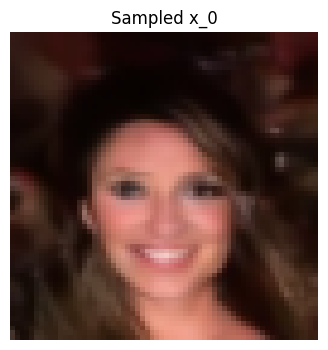

In [8]:
ddpm_cur.eval()

with torch.no_grad():
    x0,_ = sample_ddim(
        model=ddpm_cur,
        shape=shape,
        alphas_cumprod=alpha_bars,
        device=device,
        ddim_steps=ddim_steps,
        eta=eta
    )

import matplotlib.pyplot as plt
def visualize_sample(x0, idx=0):
    img = x0[idx]
    img = np.transpose(img, (1, 2, 0))
    img = (img + 1.0) / 2.0
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sampled x_0")
    plt.show()

visualize_sample(x0.cpu(),idx=0)

# Compare Reward
Finetuned model attains higher reward than trained DDPM model.

In [9]:
ddpm_old = DDPMModel().to(device)
ckpt_path = '/content/drive/MyDrive/cv프로젝트/부트캠프/_100.pth'
checkpoint = torch.load(ckpt_path, map_location="cpu")
state_dict = checkpoint["model_state_dict"] if "model_state_dict" in checkpoint else checkpoint
ddpm_old.load_state_dict(state_dict)

ddpm_old.eval()
ddpm_cur.eval()

with torch.no_grad():
    x0_old,_ = sample_ddim(
        model=ddpm_old,
        shape=(64,3,64,64),
        alphas_cumprod=alpha_bars,
        device=device,
        ddim_steps=ddim_steps,
        eta=eta
    )
    x0_cur,_ = sample_ddim(
        model=ddpm_cur,
        shape=(64,3,64,64),
        alphas_cumprod=alpha_bars,
        device=device,
        ddim_steps=ddim_steps,
        eta=eta
    )
    reward_old = rm(x0_old).mean().item()
    reward_cur = rm(x0_cur).mean().item()
    print(f"Reward Old: {reward_old:.4f}")
    print(f"Reward Cur: {reward_cur:.4f}")

Reward Old: 0.4847
Reward Cur: 0.6686
